Import required modules

In [10]:
import pydicom
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path


Access the folder path for the cancer and the non-cancer images

In [2]:
personal_path = "/Users/theon/Documents/Classes/Computing/CISC 471/Data"
non_cancerous_path = personal_path + "/Non-Cancerous-Images/abdominallymphnodes-26828"
non_cancerous_annotations_path = personal_path + "/Non-Cancerous-Images/Annotations-26828"
cancerous_path = personal_path + "/Cancerous-Images/NA-78735"
cancerous_annotations_path = personal_path + "/Cancerous-Images/Annotations-78735"


Load in all the DICOM files

In [28]:
def load_dicoms(folder_path):
    dicom_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".dcm"):
            path = os.path.join(folder_path, file_name)
            dicom_list.append(pydicom.dcmread(path))
    if dicom_list == []:
        raise ValueError("No DICOM files found in " + folder_path)
    return dicom_list

non_cancerous_ct_dicom = load_dicoms(non_cancerous_path)
non_cancerous_seg_dicom = load_dicoms(non_cancerous_annotations_path)
cancerous_ct_dicom = load_dicoms(cancerous_path)
cancerous_seg_dicom = load_dicoms(cancerous_annotations_path)

DICOM to JPG

In [36]:

def load_dicom_images(dicoms):
    images = []
    for dicom in dicoms:
        images.append(dicom.pixel_array)
    return images

non_cancerous_ct_images = load_dicom_images(non_cancerous_ct_dicom)
non_cancerous_seg_images = load_dicom_images(non_cancerous_seg_dicom)
cancerous_ct_images = load_dicom_images(cancerous_ct_dicom)
cancerous_seg_images = load_dicom_images(cancerous_seg_dicom)

In [37]:

print("Non-cancerous images loaded:", len(non_cancerous_ct_images))
print("Annotated non-cancerous images loaded:", len(non_cancerous_seg_images))
print("Cancerous images loaded:", len(cancerous_ct_images))
print("Annotated cancerous images loaded:", len(cancerous_seg_images))

Non-cancerous images loaded: 661
Annotated non-cancerous images loaded: 1
Cancerous images loaded: 134
Annotated cancerous images loaded: 1


In [45]:
def convert_to_jpg(images, output_folder):
    for i, img in enumerate(images):
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_normalized.astype("uint8")
        cv2.imwrite(f"{output_folder}/image_{i}.jpg", img_uint8)


def convert_annotations_to_jpg(images, output_folder):
    for img in images:
        # grayscale the image
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_normalized.astype("uint8")
        # since this is a 3d array, make a separate image for each layer in the 1st plane
        for i, j in enumerate(img_uint8):
            cv2.imwrite(f"{output_folder}/image_{i}.jpg", j)

convert_to_jpg(cancerous_ct_images, cancerous_path + "/images")
convert_to_jpg(non_cancerous_ct_images, non_cancerous_path + "/images")
convert_annotations_to_jpg(cancerous_seg_images, cancerous_annotations_path + "/images")
convert_annotations_to_jpg(non_cancerous_seg_images, non_cancerous_annotations_path + "/images")

Match CT and SEG Image Positions

In [ ]:
def extract_ct_positions(ct_dicoms):
    ct_positions = {}
    for dicom in ct_dicoms:
        sop_instance_uid = dicom.SOPInstanceUID if hasattr(dicom, 'SOPInstanceUID') else None
        image_position = dicom.ImagePositionPatient if hasattr(dicom, 'ImagePositionPatient') else None
        if sop_instance_uid and image_position:
            ct_positions[sop_instance_uid] = image_position
    # return a dictionary of ct image uid : ct image position
    return ct_positions

def extract_segmentation_positions(seg_dicoms):
    # This function assumes there is only 1 segmentation dicom/only the 1st segmentation dicom matters
    segmentation_positions = {}
    # Locate the first DICOM file in the segmentation directory
    dicom = seg_dicoms[0]  # Load the first segmentation file
    for frame in dicom.PerFrameFunctionalGroupsSequence:
        sop_instance_uid = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
        image_position = frame.PlanePositionSequence[0].ImagePositionPatient
        segmentation_positions[sop_instance_uid] = image_position
    # return a dictionary of referenced ct image uid : seg image position
    return segmentation_positions

def match_positions(ct_positions, segmentation_positions):
    matched_positions = {}
    for seg_uid in segmentation_positions.keys():
        if seg_uid in ct_positions:
            matched_positions[seg_uid] = {
                "CT_Position": ct_positions[seg_uid],
                "Segmentation_Position": segmentation_positions[seg_uid]
            }
    return matched_positions

# Extract positions
try:
    non_cancerous_positions = extract_ct_positions(non_cancerous_ct_dicom)
    non_cancerous_annotation_positions = extract_segmentation_positions(non_cancerous_seg_dicom)
    cancerous_positions = extract_ct_positions(cancerous_ct_dicom)
    cancerous_annotation_positions = extract_segmentation_positions(cancerous_seg_dicom)
except ValueError as e:
    print(e)

# Match positions for non-cancerous and cancerous data
non_cancer_matched_positions = match_positions(non_cancerous_positions, non_cancerous_annotation_positions)
cancer_matched_positions = match_positions(cancerous_positions, cancerous_annotation_positions)

    
# Commented out print statements to reduce output

# # Check if data was extracted
# print("Non-cancerous CT Positions:", non_cancerous_positions)
# print("Non-cancerous Annotation Positions:", non_cancerous_annotation_positions)
# print("\nCancerous CT Positions:", cancerous_positions)
# print("Cancerous Annotation Positions:", cancerous_annotation_positions)

# # Check if there are matching SOP Instance UIDs for non-cancerous data
# print("\nNon-cancerous CT SOPInstanceUIDs:", list(non_cancerous_positions.keys()))
# print("Non-cancerous Segmentation SOPInstanceUIDs:", [uid for uid, _ in non_cancerous_annotation_positions])


# # Check if there are matching SOP Instance UIDs for cancerous data
# print("\nCancerous CT SOPInstanceUIDs:", list(cancerous_positions.keys()))
# print("Cancerous Segmentation SOPInstanceUIDs:", [uid for uid, _ in cancerous_annotation_positions])

# # Check matching data
# print(non_cancer_matched_positions)
# print(cancer_matched_positions)


{'61.7.225671413567587988709540514214837207016': {'CT_Position': [-195.5, -72.5, -3.716000e+02], 'Segmentation_Position': [-195.5, -72.5, -371.599976]}, '61.7.172515939084005252437456394015127410395': {'CT_Position': [-195.5, -72.5, -3.706000e+02], 'Segmentation_Position': [-195.5, -72.5, -370.599976]}, '61.7.311273956813205555334922523590492390726': {'CT_Position': [-195.5, -72.5, -3.696000e+02], 'Segmentation_Position': [-195.5, -72.5, -369.599976]}, '61.7.49239243940168297994111164026998337905': {'CT_Position': [-195.5, -72.5, -3.686000e+02], 'Segmentation_Position': [-195.5, -72.5, -368.599976]}, '61.7.46898277701274339226472024127606534162': {'CT_Position': [-195.5, -72.5, -3.676000e+02], 'Segmentation_Position': [-195.5, -72.5, -367.599976]}, '61.7.269707611950866927630519493863211594541': {'CT_Position': [-195.5, -72.5, -3.666000e+02], 'Segmentation_Position': [-195.5, -72.5, -366.599976]}, '61.7.62418700203484400719700631085943471490': {'CT_Position': [-195.5, -72.5, -3.656000e

Overlay annotations on CT images and produce a JPEG for visualization

In [ ]:
def annotate(image, annotation):
    img = image
    for x, row in enumerate(annotation):
        for y, col in enumerate(row):
            image = cv2.circle(image, (x, y), 1, (0, 255*(col/255), 0), 1)  # Green circle
    return img

def overlay(ct_dicoms, ct_images, seg_images, matches):
    # list of all images
    images = ct_images
    match_found = 0
    # this function assumes there is only 1 segmentation dicom file/only the first segmentation dicom file matters
    img_normalized = cv2.normalize(seg_images[0], None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_normalized.astype("uint8")
    # itterate through the dicoms
    for i, ct_dicom in enumerate(ct_dicoms):
        # check if this layer should have an annotation
        if ct_dicom.SOPInstanceUID in matches:
            # this fumction assumes the ct and annotations are in the correct order
            images[i] = annotate(images[i], img_uint8[match_found])
            match_found +=1
    if match_found != len(matches):
        raise ValueError("there were " + len(matches) + "matches provided but only " + match_found + "matches found")
    return images

non_cancerous_annotated_images = overlay(non_cancerous_ct_dicom, non_cancerous_ct_images, non_cancerous_seg_images, non_cancer_matched_positions)
nc_output_folder = personal_path + "/annotated_non-cancerous_images"
for i, j in enumerate(non_cancerous_annotated_images):
    cv2.imwrite(f"{nc_output_folder}/image_{i}.jpg", j)

Load in annotations for non-cancerous tissue

[(243, 228, 366), (226, 221, 366), (276, 239, 370), (309, 268, 418)]
here


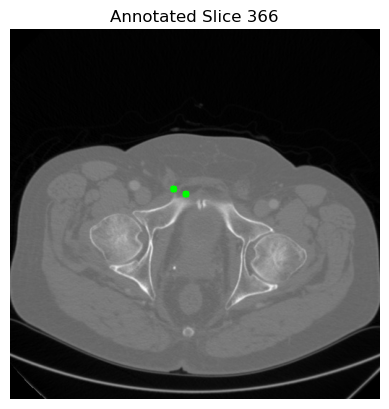

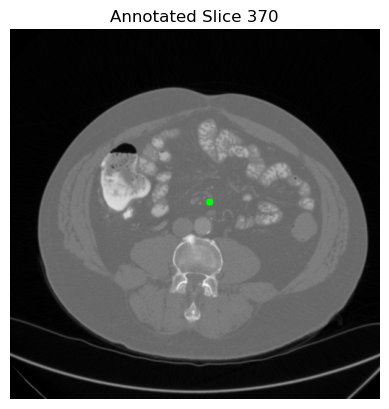

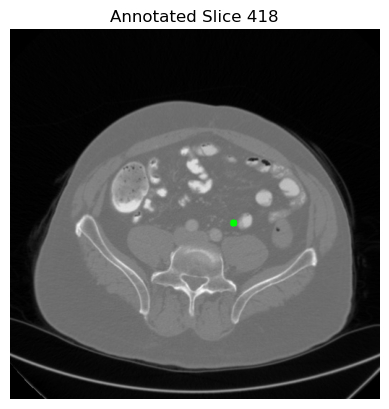

In [73]:

# Load voxel indices from TXT file
def load_voxel_indices(file_path):
    voxel_points = []
    with open(file_path, 'r') as f:
        for line in f:
            x, y, z = map(int, line.strip().split())
            voxel_points.append((x, y, z))
    return voxel_points

# Overlay voxel points on an image
def overlay_voxel_points(image, points):
    for x, y, _ in points:  # Only use x and y
        image = cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Green circle
    return image

# Process JPG images in folder
def process_jpg_with_voxel_annotations(image_folder, voxel_file, output_folder, display_limit=5):
    # Load voxel indices
    voxel_points = load_voxel_indices(voxel_file)
    print(voxel_points)
    # Counter for the number of displayed images
    images_displayed = 0

    # Iterate through JPG images in the folder
    for slice_idx, file_name in enumerate(sorted(os.listdir(image_folder))):
        if file_name.endswith(".jpg"):
            # Load the image
            image_path = os.path.join(image_folder, file_name)
            image = cv2.imread(image_path)

            # Filter points for the current slice
            slice_points = [(x, y, z) for x, y, z in voxel_points if z == slice_idx]
            if slice_idx == 366:
                print('here')

            annotated_image = overlay_voxel_points(image, slice_points)

            # Save the annotated image
            output_path = os.path.join(output_folder, f"annotated_{file_name}")
            cv2.imwrite(output_path, annotated_image)

            # Display the annotated image only if we haven't reached the display limit
            if (images_displayed < display_limit and slice_points):
                plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                plt.title(f"Annotated Slice {slice_idx}")
                plt.axis('off')
                plt.show()
                images_displayed += 1  # Increment the display counter
        
   
# Usage
image_folder = non_cancerous_path + "/images"  # Folder with JPG files
voxel_file = non_cancerous_annotations_path + "/annotations/ABD_LYMPH_001_lymphnodes_indices.txt"  # Voxel indices file
output_folder = personal_path + "/annotated_non-cancerous_images"  # Folder to save annotated images 
os.makedirs(output_folder, exist_ok=True)

process_jpg_with_voxel_annotations(image_folder,voxel_file,output_folder)


Preprocess Images for CNN

In [1]:
#Resize images
def preprocess_image(img, target_size=(224, 224)):
    img_resized = cv2.resize(img, target_size)
    return img_resized

non_cancerous_images_resized = [preprocess_image(img) for img in non_cancerous_images]
cancerous_images_resized = [preprocess_image(img) for img in cancerous_images]


#Normalization
non_cancerous_images_normalized = [img / 255.0 for img in non_cancerous_images_resized]
cancerous_images_normalized = [img / 255.0 for img in cancerous_images_resized]


NameError: name 'non_cancerous_images' is not defined

CNN

In [46]:


X = non_cancerous_images_normalized + cancerous_images_normalized
y = [0] * len(non_cancerous_images_normalized) + [1] * len(cancerous_images_normalized)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Convert lists to arrays
X_train = np.array(X_train).reshape(-1, 224, 224, 1)  # Add channel dimension if grayscale
X_test = np.array(X_test).reshape(-1, 224, 224, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [47]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (636, 224, 224, 1)
X_test shape: (159, 224, 224, 1)
y_train shape: (636,)
y_test shape: (159,)


In [48]:
X_train

array([[[[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        ...,

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]],

        [[-4.01568627],
         [-4.01568627],
         [-4.01568627],
         ...,
         [-4.01568627],
         [-4.01568627],
         [-4.01568627]]],


       [[[-4.01568627],


In [49]:
X_test

array([[[[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        ...,

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]],

        [[-7.84313725],
         [-7.84313725],
         [-7.84313725],
         ...,
         [-7.84313725],
         [-7.84313725],
         [-7.84313725]]],


       [[[-7.84313725],


In [50]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [51]:
y_test

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0])

In [52]:
train_test_split(y, shuffle=False)

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


Check Class Distribution in Train and Test Sets

In [53]:

# Assuming y_train and y_test are your labels for the train and test sets
train_class_distribution = pd.Series(y_train).value_counts(normalize=True)
test_class_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Class distribution in training set:")
print(train_class_distribution)
print("\nClass distribution in testing set:")
print(test_class_distribution)

Class distribution in training set:
0    0.836478
1    0.163522
Name: proportion, dtype: float64

Class distribution in testing set:
0    0.811321
1    0.188679
Name: proportion, dtype: float64


Cross validation and bootstrapping